# TAA4: Unsupervised learning

In this tutorial we will work with 4-digit zipcode-level data from Dutch neighbourhoods to cluster them by similarity. In this tutorial you will learn about the nuances of data pre-processing for unsupervised learning, running and evaluating KMeans, and finally about interpreting the results of unsupervised learning.

### Important before we start
---
This is a 1-week exercise rather than the 2-week exercises of the previous weeks. For that reason, it contains more pre-filled code. You will have the chance to experiment a little bit for some questions for those that find the coding too easy, though.

**❗Questions are indicated in full bold face.** They should be filled in on Canvas, and we suggest explaining your rationale and thoughts, as they are intended to test your understanding of the ML pipeline.

**⚠️ Make sure that you copy this file** before you continue, else you will lose everything. To do so, go to Bestand/File and click on Een kopie opslaan in Drive/Save a Copy on Drive!

**⚠️ Partial use of AI is allowed.** You may use it to generate code, and to check your understanding of key concepts. HOWEVER, don’t use it to generate full answers to questions. We want to see questions written in your own words!

## Learning Objectives
<hr>

* Querying data from a Web Feature Service (WFS)  
* Understanding the nuances of data processing for unsupervised learning
* Understanding metrics for unsupervised learning, as well as their downsides
* Learning to post-hoc interpret cluster centroids



## Packages
<hr>

The following packages are noteworthy in this tutorial:

[**Pandas**](https://pandas.pydata.org/docs/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

[**GeoPandas**](https://geopandas.org/) is a Python package that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

[**contextily**](https://contextily.readthedocs.io/en/latest/) Contextily provides one-line basemap loading for plotting in Python, which makes it much easier to add context to your visualized spatial data.

[**owslib**](https://owslib.readthedocs.io/en/latest/) owslib is a package that wraps requests to spatial API endpoints, such as web feature services, making it easier to load spatial data from APIs.

[**scikit-learn**](https://scikit-learn.org/stable/) is a Python package for statistical learning that is built on the general NumPy ecosystem. It is the most-used package for classical machine learning.

In [ ]:
!pip install contextily -q

In [ ]:
# Built-ins
import requests

# Data wrangling
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

# Analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score

# Dataset preparation

In this tutorial we will load a dataset straight from an API, which as you will see comes with its own set of necessary pre-processing steps. We will first download the dataset, followed by some clean-up and lastly some pre-processing steps to prepare the data for clustering.

## Load data for the Randstad area
In order to find patterns in unstructured data, we of course first need data. For our example we will use neighbourhood-level statistics provided by the Central Burea for Statistics (CBS) Netherlands. The bounding box below is set to cover the Randstad area and Noord-Holland at the 4-digit zipcode level. The script below will query the Web Feature Service (WFS) and write a local copy so that we can then load it and analyze it.

In [ ]:
# WFS endpoint for CBS Postcode4 2023
url = "https://service.pdok.nl/cbs/postcode4/2023/wfs/v1_0"

# Bounding box in EPSG:28992
bbox = (76000, 430000, 162000, 550000)

params = dict(
    service="WFS",
    version="1.0.0",
    request="GetFeature",
    typeName="postcode4:postcode4",
    srsName="EPSG:28992",
    bbox=",".join(map(str, bbox))    # Add bounding box filter
)

# Fetch raw response
response = requests.get(url, params=params)

# Save to GML
with open("zipcode4_data.gml", "w", encoding="utf-8") as f:
    f.write(response.text)

With the data written out to the virtual machine, we can load it and have a look at the table structure.

In [ ]:
# Load into GeoPandas
gdf = gpd.read_file("zipcode4_data.gml")
gdf.set_crs(epsg=28992, inplace=True)
print(f"Total number of rows: {len(gdf)}")
gdf.head()

As you can tell (maybe with the help of a translator), the dataset is comprised of a mix of demographic data, building data, distance data, and descriptive metadata about the zipcode area.

## Handle missing data
This dataset is a decent representation of what you can expect working with real-world data. It has no-data columns, as well as rows which had their values omitted for privacy reasons (e.g. in a small neighbourhood, certain demographic stats are hidden). Working with KMeans requires us to make very deliberate choices on how we handle these, as otherwise they might skew the model.

Let's first have a look at the scale of the problem. The dataset marks no-data values as any values below zero (as everything is count or demographic data). Let's first look at the columns with non-included data (code -99995). Write some code to find these columns. If you do it right, you should have 98 columns.

In [ ]:
# Find a way to create a list with columns that are invalid (code -99995)

That's about 2/3rds of the dataset! This data is present at a different spatial scale, but not at the 4-digit zipcode level. So, let's just remove these columns from the dataframe.

In [ ]:
# Drop the columns you identify from the dataframe

Next, we will look at omitted data, with the error code -99997. Identify which columns have rows with the value -99997.<br>
⚠️ BUT don't drop these columns from the dataframe.

In [ ]:
# Repeat the process for error code -99997

So there are quite a few columns with data that has been omitted. But how widespread is the problem? How frequently do they appear per row? If it's just a single no-data value every now and then, it's not a big issue. But what about when it's more widespread?

Let's look at statistics for no-data values per row.

In [ ]:
# Check rows by iterating and checking values
rows_with_missing_count = 0
total_missing_values = 0

for _, row in gdf_cleaned.iterrows():
    missing_in_row = (row == -99997).sum()
    if missing_in_row > 0:
        rows_with_missing_count += 1
        total_missing_values += missing_in_row

print("Total rows with missing data:", rows_with_missing_count)

# Calculate average number of missing columns per affected row
if rows_with_missing_count > 0:
    avg_missing_per_row = total_missing_values / rows_with_missing_count
    print("Average number of missing columns per affected row:", round(avg_missing_per_row, 2))
else:
    print("No rows with missing data found.")

So, about half of the rows in the dataframe have missing data, and on average 5 rows are affected by this. That's quite substantial, and will require a careful approach. Recall that The K-Means algorithm optimizes based on distance metrics. That is, it iterates to minimize the distance between points belonging to a certain cluster, and to maximize the distance to points outside of it. So, if we want to still use these variables, we need a numerical solution to the no-data problem.

Fortunately, we have a very simple heuristic to work with. We know that this omission happens for privacy reasons in small zipcode regions. In other words, we can generally assume that omitted data has very small quantities. We can therefore apply a straightforward stop-gap solution, namely to simply replace these no-data values with zeroes.

Building on this, we have a decision to make on whether or not we want to remove rows with excessive no-data values. Are no-data values informative or not? This is up to you as a modeller to decide. On the one hand, by our heuristic, no data-values *may* be informative, as they inform the model of the scale of the neighbourhood. On the other hand, is the size of the neighbourhood informative in itself in the clustering problem? That's up to you to decide. In the default case we're including them, but we've left some code for you to experiment with.

In [ ]:
# # Exclude rows with more than 3 columns containing -99997
# no_data_mask = (gdf_cleaned == -99997).sum(axis=1) <= 3
# gdf_filtered = gdf_cleaned[no_data_mask].copy()
gdf_filtered = gdf_cleaned

# Replace -99997 with 0 (assumed very small quantity due to small neighbourhood size)
numeric_cols = gdf_filtered.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    gdf_filtered[col] = gdf_filtered[col].replace(-99997, 0)

## Visualizing

Now that we've handled erroneous data from the dataframe, let's take a moment to visualize our data. You can change the column name to visualize other columns. `gdf_filtered.keys()` gives an overview of available columns (only in Dutch, though translators can help).

In [ ]:
# Column to visualize
col_name = "gemiddeldeWozWaardeWoning" # Housing prices estimated by the govt.

# Check if the column exists
if col_name in gdf_filtered.columns:
    # Convert to Web Mercator for basemap compatibility
    gdf_filtered_3857 = gdf_filtered.to_crs(epsg=3857) # Use gpd function `.to_crs()`

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Choropleth map
    gdf_filtered_3857.plot(
        column=col_name,
        cmap='viridis',
        legend=True,
        ax=ax1,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.5
    )
    ctx.add_basemap(ax1, crs=gdf_filtered_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)
    ax1.set_title(f"Spatial distribution of {col_name}")
    ax1.axis('off')

    # Histogram
    gdf_filtered[col_name].hist(bins=30, ax=ax2)
    ax2.set_title(f'Distribution of {col_name}')
    ax2.set_xlabel(col_name)
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{col_name}' not found in the GeoDataFrame.")

Notice in the distribution that we have some unintended side-effects, such as zeroes in the housing price. More sophisticated methods can probably solve this, but it's a bit beyond the scope of this short tutorial. Let your imagination run wild!

❗**Q1: In the case presented in this tutorial, everything gets assigned to zeroes because we have prior knowledge on the structure of the underlying data. In cases where data is missing and we don't have prior knowledge, which other solutions can you come up with to impute these values?**

## Fix non-ratio'd columns

Now that we have fixed our dataset, we can have a look at the actual structure of the columns. Let's visualize a couple of rows again to inspect what kinds of values are found in each column.

In [ ]:
gdf_filtered.head()

*"Inwoner"* translates to "inhabitant". Notice that we have columns with counts. If you think about how KMeans predicts, you'll understand that these counts are not informative, because zipcode areas are not uniform in size. Instead, we should convert everything to ratios, as these can be compared between areas. Fortunately, we have total counts of everything that we should ratio. The code provided below will do this for you.

In [ ]:
def make_ratios(gdf_to_ratio):
    gdf_ratio = gdf_to_ratio.copy() # Otherwise we overwrite the original gdf
    cols = gdf_ratio.columns

    # 1. Population ratios
    pop_cols = [col for col in cols if col in ['aantalMannen', 'aantalVrouwen'] or col.startswith('aantalInwoners')]
    for col in pop_cols:
        if col != 'aantalInwoners':
            gdf_ratio[col] = np.where(gdf_ratio['aantalInwoners'] != 0, gdf_ratio[col] / gdf_ratio['aantalInwoners'], 0)

    # 2. Household ratios
    hh_cols = [col for col in cols if 'huishoudens' in col and col != 'gemiddeldeHuishoudensgrootte' and col != 'aantalPartHuishoudens']
    for col in hh_cols:
        gdf_ratio[col] = np.where(gdf_ratio['aantalPartHuishoudens'] != 0, gdf_ratio[col] / gdf_ratio['aantalPartHuishoudens'], 0)

    # 3. Housing ratios
    woning_cols = [col for col in cols if col.startswith('aantalWoningen') and col != 'aantalWoningen']
    for col in woning_cols:
        gdf_ratio[col] = np.where(gdf_ratio['aantalWoningen'] != 0, gdf_ratio[col] / gdf_ratio['aantalWoningen'], 0)

    return gdf_ratio

gdf_ratiod = make_ratios(gdf_filtered)
gdf_ratiod.head()

❗**Q2: How do you think that the model behave if we don't convert columns like this? Could the model theoretically still learn ratio differences between neighbourhoods? Think hard about how K-Means classification works (distance-based optimization problem), and what transforming into ratios is supposed to solve.**

*Simply put, the model would separate zipcode areas by the total size of the population, rather than by the relative differences between population groups. In effect, it would not use the variables in a way that we'd like them to, because we understand that demographic information is supposed to be used to compare neighbourhoods by their composition, rather than their flat counts.*

*In this case, transforming to ratios shrinks and transforms variables through divison by a given total. Realize that this process inherently transforms distance. K-Means is entirely based on minimizing and maximizing distance, and it doesn't learn the relationship between variables. As such, if we don't convert sub-categories to ratios, then the only meaningful signal to the model is the size of the municipality size, and not their relative differences. By turning variables into ratios, we move the focus away from the relative size of municipalities, and more so on the relationship between variables. Because K-Means does not encode (i.e. it does not learn, only solve), we need to make this information explicit, otherwise the model will focus simply on the relative inhabitant size difference between zipcode regions, and not take into account demographic distributions.*

### **Normalizing**

As mentioned, KMeans models minimize a distance objective function, where the dsitance is determined by the values of the variables. This means that a variable with values in the range 100 to 1'000 will have a much stronger effect on the model's decision boundary than a variable with values ranging from 0.0 to 1.0. As such, it's good practice to normalize variables, so that they have the same importance to the model. To do this, we can *standardize* each variable (also called z-score normalization):

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- \( x \) is the original variable value  
- \( \mu \) is the mean of the variable
- \( \sigma \) is the standard deviation of the variable

Let's apply it to each column that we intend to include in the clustering problem.

In [ ]:
numeric_cols = gdf_ratiod.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if not col in ["postcode"]]

scaler = StandardScaler()
gdf_norm = gdf_ratiod.copy()
gdf_norm[numeric_cols] = scaler.fit_transform(gdf_norm[numeric_cols])

gdf_norm.head()

Now, all of the values above are z-score normalized, which brings them all to the same range while still preserving meaningful differences compared to the mean of each variable.

❗**Q3: z-score normalization isn't the only way to normalize data. We can also normalize to a 0-1 range by min/max normalizing: `(value - min) / (max - min)`. What are the benefits and downsides of using this method of normalizing, especially compared to z-score normalization? When would it be suitable to use compared to z-score normalization?**

# Clustering

## Running and evaluating K-Means clustering

Now that we've prepared the data, we can move towards clustering it. A constant problem with unsupervised learning is deciding which model is the 'right' model. Numerical quantities have been invented for this, which mostly describe the quality of the optimization outcome based on the intended function of KMeans (maximize distance to out-of-cluster points, minimize distance between points within same cluster). Let's quickly discuss these three metrics in order to understand what they're supposed to signal.

**Inertia**

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

Where:
- \( k \) is the number of clusters  
- \( C_i \) is the set of points in cluster \( i \)  
- \( \mu_i \) is the centroid of cluster \( i \)

Inertia measures the sum of squared distances between each point and the centroid of its assigned cluster. In effect, it tells you how tightly-packed clusters are. Understand though that adding more clusters *always* reduces inertia, so it's not just a matter of picking the lowest inertia. Usually these plots are eyeballed for the most obvious break-point with the "elbow method", where you look at where the inertia loss from adding new clusters has diminishing returns. Yes, this is pretty subjective, but that's a recurring theme in unsupervised learning. It's a data exploration tool first and foremost.

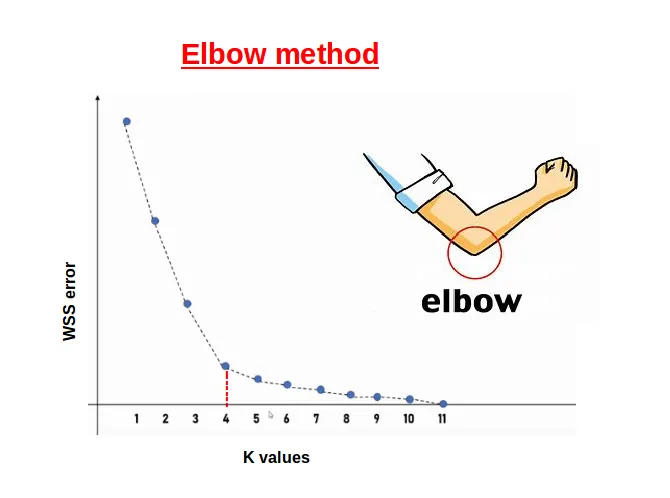
<br>
([Zala Rushirajsinh on Medium, 2023](https://medium.com/@zalarushirajsinh07/the-elbow-method-finding-the-optimal-number-of-clusters-d297f5aeb189))

**Calinski-Harabasz Index**

$$
\text{CHI} = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

Where:
- \( \text{Tr}(B_k) \) is the trace of the between-cluster dispersion matrix  
- \( \text{Tr}(W_k) \) is the trace of the within-cluster dispersion matrix  
- \( n \) is the number of samples  
- \( k \) is the number of clusters

The Calinski-Harabasz Index measures the ratio of between-cluster dispersion to within-cluster dispersion, adjusted for the number of clusters and data points. More simply put, it compares how far apart clusters are, compared to how compact they are.

Higher ratio values indicate tighter, more spread-out clusters, which means a better numerical solution. Here, we can look for diminishing returns, similar to the elbow method.

**Davies-Bouldin Index**
$$
\text{DBI} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{\sigma_i + \sigma_j}{d_{ij}} \right)
$$

Where:
- \( \sigma_i \) is the average distance of all points in cluster \( i \) to the centroid of cluster \( i \)  
- \( d_{ij} \) is the distance between the centroids of clusters \( i \) and \( j \)  
- \( k \) is the number of clusters

The Davies-Bouldin index measures the average similarity between each cluster and its most similar one, where similarity is a ratio of within-cluster scatter to between-cluster separation. Simply put once again, it looks at how similarly-dispersed clusters are. Lower values are better, as the objective is to create minimal overlap between all clusters.

Now let's plot these three metrics and see what we get...

In [ ]:
def plot_kmeans_metrics(X, cluster_range=range(2, 11)):
    """
    Plots KMeans clustering metrics (inertia, Calinski-Harabasz, Davies-Bouldin)
    side-by-side for a given dataset and cluster range.

    Parameters:
    - X: ndarray or DataFrame, shape (n_samples, n_features)
    - cluster_range: iterable of integers, number of clusters to evaluate
    - filename: str, name of the output image file
    """
    inertias = []
    ch_scores = []
    db_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        ch_scores.append(calinski_harabasz_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    axes[0].plot(cluster_range, inertias, marker='o')
    axes[0].set_title('Inertia (lower=better)')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Value')

    axes[1].plot(cluster_range, ch_scores, marker='o', color='green')
    axes[1].set_title('Calinski-Harabasz Index (higher=better)')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Value')

    axes[2].plot(cluster_range, db_scores, marker='o', color='red')
    axes[2].set_title('Davies-Bouldin Index (lower=better)')
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

In [ ]:
X = gdf_norm[numeric_cols].values
plot_kmeans_metrics(X)

But wait, that's strange? Why are these metric plots so strange? For inertia, there is no clear elbow. For CHI, cluster overlap seems to increase as we add clusters. DBI behaves erratically, with no clear best choice either (maybe 9..?)

Let's have a look at the clusters that it actually produces to try to make sense of it. Let's use k=4, since the "elbow" seems most promising here.

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
labels = kmeans.fit_predict(X)

gdf_norm['cluster_label'] = labels

In [ ]:
# Convert to Web Mercator for contextily
gdf_norm_3857 = gdf_norm.to_crs(epsg=3857)

# Plot choropleth
fig, ax = plt.subplots(figsize=(10, 10))
gdf_norm_3857.plot(
    column='cluster_label',
    cmap='viridis',
    legend=True,
    ax=ax,
    alpha=0.5,
    edgecolor='k',
    linewidth=0.5
)
ctx.add_basemap(ax, crs=gdf_norm_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Neighbourhood clusters")
plt.axis('off')
plt.tight_layout()
plt.show()

Let's have a look at the clusters that it actually produces to try to make sense of it. Let's use k=4, since the "elbow" seems most promising here.

So, by our cluster metrics, the results shouldn't necessarily be better with more clusters. However, the computed clusters seem to have clear and logical patterns, namely the degree of urbanisation within each postcode:
1. Areas with the Groene Hart ("green heart", between Rotterdam and Utrecht) almost all belong to the same cluster. **This cluster is shared with the more rural and less populated zipcodes**.
2. Another *cluster captures most of the suburban* and less densely populated urban towns and cities.
3. Thirdly, **there is a clear urbanism cluster** which covers more densely-populated areas, such as Leiden, Delft, Amsterdam, Utrecht, and Rotterdam.
4. **The final cluster seems to be correlated with industry**. In the south, Rotterdam Botlek shows up as part of this cluster, and so does Amsterdam Westpoort near Amsterdam. Both of these are shipping areas. This might have been informed by the lack of population data in this area, as these zipcodes are mostly buildings without many inhabitants, and without housing prices (as these are given for residential buildings only).

As can be seen, unsupervised learning is essentially a way to extract key take-aways from the input variables, and a-priori you often don't know what you're going to get out of it.

❗**Q4: Why does the CHI metric decrease instead of increase in this context, when seemingly logical clusters can be formed? (HINT: Think about how cities tend to form a gradient, in combination with what the CHI metric is supposed to be measuring).**

Feel free to check how the clusters change with different values of K - see if you can make sense of them still! The next section will continue with `k=4`.

# Analysis of clusters

Now that we have our clusters and a spatial understanding of what they mean, we can also attempt to understand them numerically. First, let's make a dataframe with just the variables so that we can compute summary statistics over them.

In [ ]:
# Copy and clean the GeoDataFrame
gdf_analysis = gdf_norm.copy()
gdf_analysis = gdf_analysis.drop(['geometry', 'postcode', 'gml_id', 'fuuid'], axis=1, errors='ignore')

# Separate features and cluster labels
features = gdf_analysis.drop(columns='cluster_label')
labels = gdf_analysis['cluster_label']

With cluster-level summary statistics in place, we can have a look at the means and the trends of each variable. But wait, we have 40+ variables, how are we going to make sense of this?

We can use tools from supervised learning to help out here. Specifically, we can treat it as a reconstruction problem, where the label is the dependent variable, and the variables of the dataframe are independent variables used to predict it. By doing so, we can understand which of the 40+ variables are most important for splitting the space into distinct clusters. You learned how to do this last week, so let's do this here too. We're going to fit and train on the entire dataset at once, so do the following:
1. instantiate a `RandomForestClassifier` using the given number of trees
2. using `features` and `labels`, train the model
3. predict values on the training features using `rf.predict(features)`
3. Calculate and print the accuracy of the model using `accuracy_score`. Simply evaluate it on `labels` and the predict

In [ ]:
# Instantiate a `RandomForestClassifier` using `features` and `labels`
# Then, use `accuracy
n_trees = 100
rf = RandomForestClassifier(...

❗**Q5: What does this perfect accuracy score mean? And why do we purposely not split the dataset into train, val, and test sets?**

Now that we have reconstructed the clusters derived with unsupervised methods, we can apply a tool you learned about last week: *feature importance*. Recall that feature importance in the context of RF models is how likely a split in a tree with this variable is to partition an example into different classes. Can you see how this translates to separability between clusters in this case?

❗**Q6: In your own words, explain how Random Forest feature importance helps to explain which variables have the greatest influence on forming clusters.**

Now that we've fitted our model, we can have a look at the most important features for splitting the clusters.

In [ ]:
# Get feature importances from the Random Forest model
# Be sure to sort by the importance. It can be found in the `rf` variable
# Remember what you learned in last week's TAA!
importance =

# Plot feature importances
# Assumed to be a Pandas dataframe with column importance in order
# Change the code or the approach if you use a different data structure
x_feats = important_features.values
y_feats = important_features.index

plt.figure(figsize=(10, 6))
sns.barplot(x=x_feats, y=y_feats, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

You can translate these most important variables with the help of Google Translate, simply print and copy-paste the entire output:



In [ ]:
print([k for k in important_features.keys()])

To better understand each variable, we can also look at their distribution within each cluster, to understand if a variable correlates positively, neutrally, or negatively with each cluster. Have a look at the summary plots below, and try to interpret them. Remember that these are z-score normalized variables. A positive score means an above average large quantity of the , whereas a negative z-score means that there is very little of it present.

Try to plot or print aggregation statistics for each cluster (mean, std, min, max) for the most important variables. HINT: Pandas has `.groupby` and `.agg` functions that would be useful for this!

In [ ]:
# Plot or print descriptive statistics for each important feature
# Again assumed to be a Pandas dataframe, but feel free to use your own approach

Have a look at some of the means and standard deviations and try to understand how they relate to the clusters.

❗**Q7: Which numerical conclusions are you able to derive from the clusters? Are you able to make sense of the clusters? Which trends and patterns emerge for each of these clusters based on the most important variables?**

* *cluster 0 shows clear demographic trends towards modern urban dwellers. Younger, more international, more one-person households, and more densely urban.*

* *Similarly, cluster 1 shows trends for suburban and peripheral living, such as more families, fewer multi-family houses, with more Dutch nationals.*

* *In that sense, these results corroborate the visual analysis of the maps, although not all variables are clear and easy to explain, and it should be clear that there is still a lot of manual interpretation and implicit narrative-forming involved, with potentially contrasting narratives able to be found in the data.*

# Wrapping up
That concludes our general introduction to the workflow of exploration using unsupervised learning. Hopefully you now understand why unsupervised methods are quite strongly up to interpretation, but also how they can lead to surprising results and emerging patterns. You've learned to prepare data for unsupervised classification, some of the pre-processing decisions that you have to make before exploring, and finally the process of exploration using KMeans Clustering. You've learned about the metrics that you can use to analyze this type of unsupervised learning problem, but also learned how these metrics don't always tell the full story of what the data is trying to express. Lastly, you've learned some methods for the post-hoc analysis of clusters, and how you can try to make sense of the main patterns for each cluster. Ultimately, unsupervised learning is an exploration tool that is only as good as its user, and ultimately it still requires human interpretation to understand what each cluster represents.

So go out there and cluster, but remember to be sure to explain your decisions in the clustering process!

**Bonus!**<br>
While coming up with this tutorial, we also used Principal Component Analysis (PCA) to try to reduce the dimensionality of the data, to see if patterns would change. Ultimately this did not matter, but we decided to keep it in to show you how PCA can be used to reduce the number of variables, which makes the prediction problem easier in case you're dealing with the curse of dimensionality (more variables than datapoints)

## Using PCA to reduce dimensionality

PCA is a method that reduces the dimensionality of data by summarizing the variance (main patterns) across all variables. In that sense, it's similar to KMeans, but its purpose is usually to reduce the number of variables, rather than to be interpreted. Here, we use PCA to reduce the total number of variables that will be used in the model.

In [ ]:
# Assume gdf_norm is your normalized DataFrame (numeric columns only, no geometry)
X = gdf_norm[numeric_cols].values  # or the columns you want to use

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

Based on the above plot, you pick the number of components. Usually you pick a number of components that explain ~90% of the variance.

In [ ]:
n_components = 12

# Reduce data to n_components
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

### Re-run and re-interpret

In [ ]:
plot_kmeans_metrics(X_reduced)

The patterns in the plots haven't changed in a meaningful manner, which indicates that PCA doesn't do much to generate better separable clusters.

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
labels = kmeans.fit_predict(X_reduced)

gdf_norm['cluster_label'] = labels

In [ ]:
# Convert to Web Mercator for contextily
gdf_norm_3857 = gdf_norm.to_crs(epsg=3857)

# Plot choropleth
fig, ax = plt.subplots(figsize=(10, 10))
gdf_norm_3857.plot(
    column='cluster_label',
    cmap='viridis',
    legend=True,
    ax=ax,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)
ctx.add_basemap(ax, crs=gdf_norm_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Neighbourhood clusters")
plt.axis('off')
plt.tight_layout()
plt.show()

Here we can see that the main patterns are still the same, and the PCA hasn't resulted in any meaningful shifts. However, if we would have a problem with many more variables than rows, PCA could be used to generate more meaningful clusters.